# Monte Carlo Sampling

This notebook covers sampling by:
* Monte Carlo
* Accept Reject
* Inverting the CDF

as well as calculating the corresponding uncertainties


### MC intergration
The equation of the circle with unit radius centered around (0; 0) is given by
$$x^2 + y^2 = 1$$
Exploiting the symmetry of the circle, one can define the area under the positive quadrant
$$\int_{0}^{1} y \, dx = \int_{0}^{1} \sqrt{1 - x^2} = \pi / 4$$
Using the Monte Carlo technique evaluate the integral to find the value of $\pi$.

We implement this information into a function and import the necessary libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def monte_carlo_pi(num_samples:int, num_exp:int) -> "y":
    """
    Generates points and checks whether they are located inside the unit circle
    :param num: number of point
    :return:  pi estimate
    """

    return np.sqrt(1 - np.random.uniform(low=0, high=1, size=(num_exp, num_samples)) ** 2)

First we generate Nsmpl = 10000 random values for x, distributed uniformly between 0 and 1. We use these values to calculate the average function value $\bar{y}$ and estimate $\pi$.

In [5]:
pi_est= np.mean(monte_carlo_pi(num_samples = int(1e4), num_exp = 1)) * 4
y_avg = pi_est / 4
print(f"Pi: {pi_est}\ny: {y_avg}")

Pi: 3.1341736736749297
y: 0.7835434184187324


We repeat this task Nexpt = 1000 times to evaluate the uncertainty due to the limited sample size used in the estimation of $\pi$

In [14]:
est = np.mean(monte_carlo_pi(num_samples = int(1e4), num_exp = int(1e3)), axis = 1)
sigma = np.std(est)
print(f"Sigma: {sigma:.5f}")

Sigma: 0.00222


For different integration samples sizes (i.e. Nsmpl = $10^i$, i = 1,....,6) which are repeated Nexpt = 100 times, evaluate the mean of the absolute difference between estimated $\pi_{est}$ and exact result $\pi$ (np.pi) i.e. $\Delta_{\pi}$ = $|\pi_{est} - \pi|$. Make a log-log plot of $\Delta_\pi$ Vs Nsmpl and show that the data can be fit to a straight line of slope -1/2.

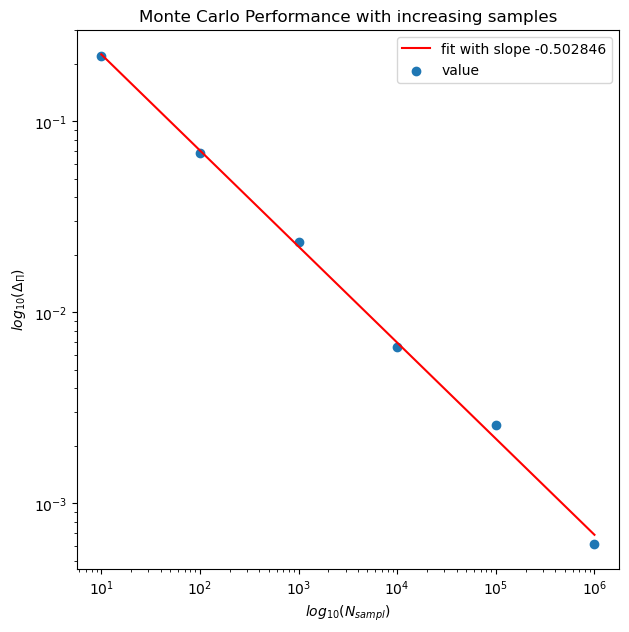

In [19]:
# define the arrays to initialize exp
N_exp = int(1e2)
a_N_samples = np.array([10 ** i for i in range(1, 7)])
pi_deltas = np.zeros(len(a_N_samples))

# monte carlo intergration and mean delta extraction
for i, N_sampl in enumerate(a_N_samples):
        pi_deltas[i] = np.mean(abs(np.mean(monte_carlo_pi(num_samples=N_sampl, num_exp=N_exp), axis = 1) * 4 - np.pi))

# fit function
line = lambda x, a, b: a * x + b
a, b = curve_fit(line,
                  np.log10(a_N_samples),
                  np.log10(pi_deltas),
                  p0 = [-0.5, 0])[0]

# plot and log transform axes
plt.figure(figsize = (7, 7))
plt.plot(a_N_samples,  10**line(np.log10(a_N_samples),a, b), color="red", label = "fit with slope {:2f}".format(a))  # ask why it doesnt plot the rigth thing
plt.scatter(a_N_samples, pi_deltas, label = "value")
plt.xscale("log", base = 10)
plt.yscale("log", base = 10)
# label axes and save
plt.xlabel("$log_{10}(N_{sampl})$")
plt.ylabel("$log_{10}({\Delta}_{\Pi})$")
plt.title("Monte Carlo Performance with increasing samples")
plt.legend()

### Importance sampling

For different integration samples sizes (i.e. Nsmpl = 1), repeated Nexpt =100 times, evaluate the mean of the absolute difference between the numerical estimate of the integral of the function $f(x) = x^3$ between x = 0 and x = 1 ($I_{est}$) and the theoretical estimate (I) i.e. $\Delta_I$ = $|I_{est} - I|$. We plot $\Delta_I$ Vs Nsmpl for two cases:

* One where the $I_{est}$ is estimated by generating random values of x distributed uniformly between 0 and 1.
* One where the $I_{est}$ is estimated by generating random values of x distributed according to a power law (i.e. $q(x) = (k + 1)x^k$, with k = 2.5 and x in [0, 1]).

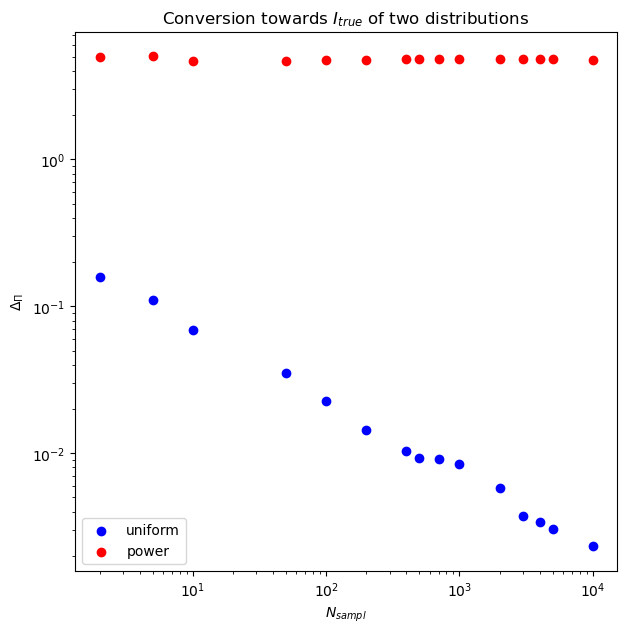

In [6]:
def f1(num_exp, num_samples):
    return np.random.uniform(low=0, high=1, size=(num_exp, num_samples)) ** 3

def f2(num_exp, num_samples, k):
    return ((k+1) * np.random.uniform(low=0, high=1, size=(num_exp, num_samples)) ** k) ** 3

I_true = 1/4 * 1**4 # solve the integral from 0 to one
N_samples = [2, 5, 10, 50, 100, 200, 400, 500, 700, 1000, 2000, 3000, 4000, 5000, 10000]
uniform_deltas = np.zeros(len(N_samples))
power_deltas = np.zeros(len(N_samples))

for i, N_smpl in enumerate(N_samples):
    # 2a
    uniform_deltas[i] = np.mean(abs(np.mean(f1(num_exp=int(1e2), num_samples=N_smpl), axis = 1) - I_true))
    # 2b
    power_deltas[i] = np.mean(abs(np.mean(f2(num_exp=int(1e2), num_samples=N_smpl, k = 2.5), axis = 1) - I_true))

plt.figure(figsize = (7, 7))
plt.scatter(N_samples, uniform_deltas, c = "blue", label = "uniform")
plt.scatter(N_samples, power_deltas, c= "red", label="power")
# plt.plot(a_N_samples, a_N_samples * -0.5 + b[0])
plt.xlabel("$N_{sampl}$")
plt.ylabel("${\Delta}_{\Pi}$")
plt.xscale("log")
plt.yscale("log")
plt.title("Conversion towards $I_{true}$ of two distributions")
plt.legend()

### Random Sample Generator
Now, we write some code that generates random numbers distributed according to a Breit-Wigner distribution with the statistical median m = 3 and the full-width at half maximum b = 7. Use for the PDF and CDF the following expressions:
$$p(x) = \frac{1}{\pi} \frac{b}{(x-m)^2 b^2$$
$$F(x) = \frac{1}{2} + \frac{1}{\pi} arctan \left(\frac{x-m}{b}\right)$$
Generate Nsmpl = 10000 accepted values of x, distributed according to p(x) using the following methods:
* accept-reject
* invert the cdf


Text(0.5, 1.0, 'Explore CDF')

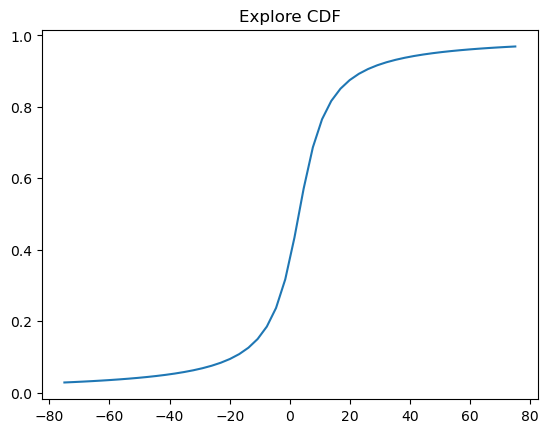

In [8]:
# implement distribution
def pdf(x, m = 3, b = 7):

    return 1 / np.pi *  b / ((x - m)**2 + b**2)

def cdf(x, m = 3, b = 7):

    return 0.5 + 1 / np.pi * np.arctan((x-m)/b)

def inverse_cdf(x, m = 3, b = 7):

    return b * np.tan((x - 0.5) * np.pi) + m

N_sampl = int(1e5)

# accept reject sampling
bins = N_sampl // 1000
xmin = -75
xmax = 75
# we see that the range where the methods work lie approx in y = [0.15, 0.85]
# first explore the CDF
plt.figure()
plt.plot(np.linspace(xmin, xmax), cdf(np.linspace(xmin, xmax)))
plt.title("Explore CDF")

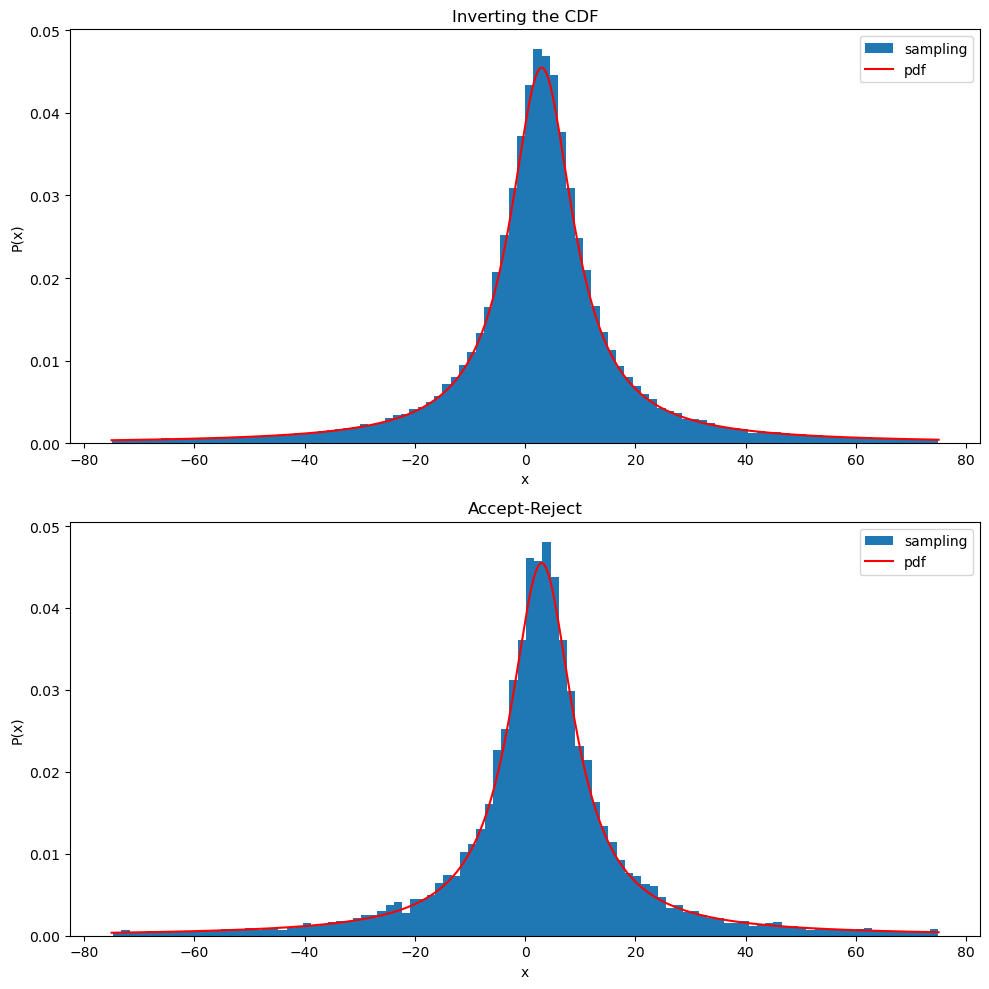

In [9]:
# accept-reject sampling
pmax = max(pdf(np.linspace(xmin, xmax, N_sampl)))
x = np.random.uniform(low=xmin, high=xmax, size=N_sampl)
y = np.random.uniform(low=0, high=pmax, size=N_sampl)
px = pdf(x = x)
acc = y<px
ar_e = x[acc].size / x.size # effiency

# invert the CDF sampling
U = np.random.uniform(low = cdf(xmin), high = cdf(xmax), size = N_sampl) # todo: find out how to use invert the cdf
x = inverse_cdf(U)

# plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 10))

# plt.figure()
ax1.hist(x, bins = bins, density=True, label = "sampling")
ax1.plot(np.linspace(xmin, xmax, N_sampl), pdf(np.linspace(xmin, xmax, N_sampl)), color="red", label="pdf")
ax1.set_xlabel("x")
ax1.set_ylabel("P(x)")
ax1.set_title("Inverting the CDF")
ax1.legend()
# plot accept reject
# plt.figure()
# plt.hist(x, bins = bins)
ax2.hist(x[acc], bins = bins, density = True, label = "sampling")
ax2.plot(np.linspace(xmin, xmax, N_sampl), pdf(np.linspace(xmin, xmax, N_sampl)), color = "red", label = "pdf")
ax2.set_xlabel("x")
ax2.set_ylabel("P(x)")
ax2.set_title("Accept-Reject")
ax2.legend()
plt.tight_layout()

### Uncertainty estimation comparison
The file *gauss_data.txt* contains 100 random numbers generated according to a Gaussian distribution with $\mu$ = 10 and $\sigma$ = 3. We want to estimate the uncertainty of these parameters using the data in three different ways.

First, we calculate the mean and standard deviation (Sx) of the data.

In [10]:
data = np.loadtxt("data/gauss_data.txt")
mu_given = 10
std_given = 3

# A
mean = np.mean(data)
std = np.std(data)
print(f"From data, mean is {mean:.3f} and std is {std:.3f}")

From data, mean is 10.060 and std is 2.989


Next, we calculate the uncertainty of these estimates using the standard formulae:
* $\sigma(\bar{x}) = S_x / \sqrt{N}$
* $\sigma(S_x) = \frac{S_x}{\sqrt{2N - 2}}$

In [12]:
sigma_mean = std / len(data) ** 0.5
sigma_std = std / (2 * len(data) - 2) ** 0.5
print(f"Uncetrainties according to the formulae for the mean is {sigma_mean:.3f} and for std it is {sigma_std:.3f}")

Uncetrainties according to the formulae for the mean is 0.299 and for std it is 0.212


Now, we use Monte Carlo to generate repetitions of the dataset Nexpt = 1000 times (i.e. 1000x100 data points) according to the underlying Gaussian distribution. Again, we calculate the mean and standard deviation for each generated dataset and use the RMS of those values to estimate the uncertainties of the mean and standard deviation of the original dataset in the text file.

In [14]:
# MC sampling
N_sampl = 1000
N_exp = 100

exp = np.random.normal(loc = mu_given, scale = std_given, size = (N_sampl, N_exp))
exp_means = exp.mean(axis = 1)
exp_std = exp.std(axis = 1)

# RMS for uncertainty
RMS = lambda data: ((data ** 2).sum() / len(data)) ** 0.5
MC_sigma_mean = RMS(exp_means - mu_given) # sib
MC_sigma_std = RMS(exp_std - std_given)
print(f"Monte Carlo leads to a mean of {exp_means.mean():.3f} +/- {MC_sigma_mean:.3f} and a std of {exp_std.mean():.3f} +/- {MC_sigma_std:.3f}")

Monte Carlo leads to a mean of 9.993 +/- 0.310 and a std of 2.964 +/- 0.209


Then, we bootstrap the dataset 1000 times by resampling the dataset with replacement. As before, we calculate the mean and standard deviation for each bootstrapped dataset and use the variance of those values to estimate the uncertainties of the mean and standard deviation of the original dataset in the text file.

In [16]:
 N_straps = 1000
idx = np.random.uniform(low = 0, high = len(data)-1, size = (N_straps, len(data))).astype(int)
bootstraps = np.array([data[i] for i in idx])
sigma_boot_means = bootstraps.mean(axis = 1).var()
sigma_boot_std = bootstraps.std(axis = 1).var()
print(f"Bootstrapping leads to a uncertainty of the mean of  +/- {sigma_boot_means:.3f} and on the std of +/- {sigma_boot_std:.3f}")

Bootstrapping leads to a uncertainty of the mean of  +/- 0.087 and on the std of +/- 0.031


**Finally, we as ourselves: Which uncertainty technique do you think can be trusted in most situations?**

It is case dependent. If the underlying PDF is known and possible to integrate, the analytical formulae are suited.
However, if this is not the case it is appropriate to use Monte Carlo. Sometimes, we cannot use MC either because we know to less about the underlying physics of the data, and this would be the scenario to use bootstrapping. For this case where the underlying PDF is known, the use of analytical formulae would be the best in terms of CPU efficiency.
